##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates manual image manipulations and augmentation using `tf.image`.

Data augmentation is a common technique to improve results and avoid overfitting, see [Overfitting and Underfitting](../keras/overfit_and_underfit.ipynb) for others.

## Setup

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

Let's check the data augmentation features on an image and then augment a whole dataset later to train a model.

Download [this image](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg), by Von.grzanka, for augmentation.

 8192/17858 [============>.................] - ETA: 0s

24576/17858 [=========================================] - 0s 0us/step


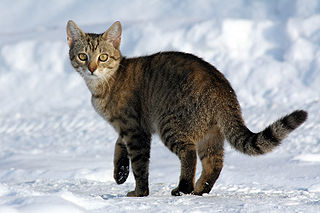

In [4]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

Read and decode the image to tensor format.

In [5]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

A function to visualize and compare the original and augmented image side by side.

In [6]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

## Augment a single image

### Flipping the image
Flip the image either vertically or horizontally.

In [7]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image
Grayscale an image.

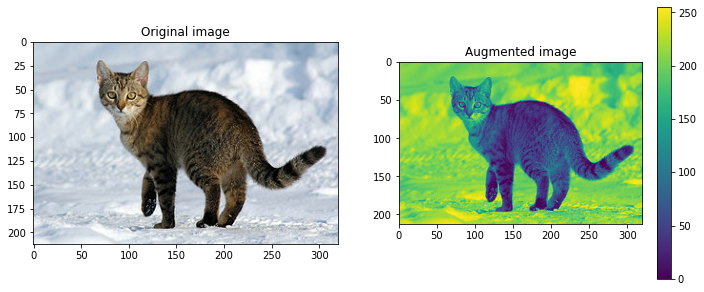

In [8]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

### Saturate the image
Saturate an image by providing a saturation factor.

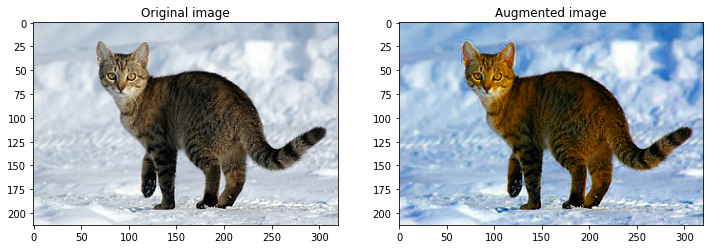

In [9]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### Change image brightness
Change the brightness of image by providing a brightness factor.

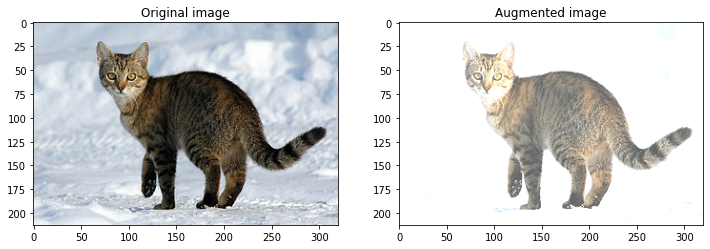

In [10]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Rotate the image
Rotate an image by 90 degrees.

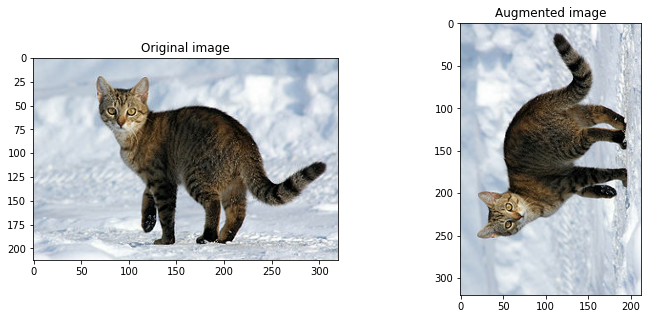

In [11]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Center crop the image
Crop the image from center upto the image part you desire.

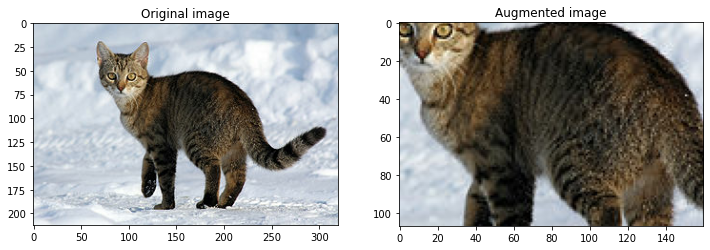

In [12]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

See the `tf.image` reference for details about available augmentation options.

## Augment a dataset and train a model with it

Train a model on an augmented dataset.

Note: The problem solved here is somewhat artificial. It trains a densely connected network to be shift invariant by jittering the input images. It's much more efficient to use convolutional layers instead.

In [13]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

Write a function to augment the images. Map it over the the dataset. This returns a dataset that augments the data on the fly.

In [14]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [15]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

Create the augmented dataset.

In [16]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

And a non-augmented one for comparison.

In [17]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

Setup the validation dataset. This doesn't change whether or not you're using the augmentation.

In [18]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

Create and compile the model. The model is a two layered, fully-connected neural network without convolution.

In [19]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

Train the model, **without** augmentation:

In [20]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50


 1/32 [..............................] - ETA: 0s - loss: 2.3103 - accuracy: 0.0625

17/32 [==============>...............] - ETA: 0s - loss: 1.1791 - accuracy: 0.6719

32/32 [==============================] - 1s 24ms/step - loss: 0.8298 - accuracy: 0.7632 - val_loss: 0.4302 - val_accuracy: 0.8679


Epoch 2/50
 1/32 [..............................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9219

17/32 [==============>...............] - ETA: 0s - loss: 0.2189 - accuracy: 0.9329

32/32 [==============================] - 0s 11ms/step - loss: 0.1916 - accuracy: 0.9365 - val_loss: 0.2829 - val_accuracy: 0.9174


Epoch 3/50
 1/32 [..............................] - ETA: 0s - loss: 0.0445 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.0683 - accuracy: 0.9800

32/32 [==============================] - 0s 11ms/step - loss: 0.0767 - accuracy: 0.9790 - val_loss: 0.3161 - val_accuracy: 0.9200


Epoch 4/50
 1/32 [..............................] - ETA: 0s - loss: 0.0333 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.0480 - accuracy: 0.9844

32/32 [==============================] - 0s 11ms/step - loss: 0.0479 - accuracy: 0.9834 - val_loss: 0.2869 - val_accuracy: 0.9288


Epoch 5/50
 1/32 [..............................] - ETA: 0s - loss: 0.0629 - accuracy: 0.9688

17/32 [==============>...............] - ETA: 0s - loss: 0.0543 - accuracy: 0.9871

32/32 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.9844 - val_loss: 0.3829 - val_accuracy: 0.9131


Epoch 6/50
 1/32 [..............................] - ETA: 0s - loss: 0.0193 - accuracy: 1.0000

16/32 [==============>...............] - ETA: 0s - loss: 0.0285 - accuracy: 0.9883

32/32 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9897

32/32 [==============================] - 0s 12ms/step - loss: 0.0256 - accuracy: 0.9897 - val_loss: 0.3398 - val_accuracy: 0.9259


Epoch 7/50
 1/32 [..............................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9844

17/32 [==============>...............] - ETA: 0s - loss: 0.0162 - accuracy: 0.9945

32/32 [==============================] - 0s 12ms/step - loss: 0.0319 - accuracy: 0.9873 - val_loss: 0.4736 - val_accuracy: 0.9062


Epoch 8/50
 1/32 [..............................] - ETA: 0s - loss: 0.0505 - accuracy: 0.9688

17/32 [==============>...............] - ETA: 0s - loss: 0.0531 - accuracy: 0.9835

32/32 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9844

32/32 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 0.9844 - val_loss: 0.3795 - val_accuracy: 0.9209


Epoch 9/50
 1/32 [..............................] - ETA: 0s - loss: 0.0183 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 0.0365 - accuracy: 0.9816

32/32 [==============================] - 0s 12ms/step - loss: 0.0408 - accuracy: 0.9834 - val_loss: 0.4602 - val_accuracy: 0.9109


Epoch 10/50
 1/32 [..............................] - ETA: 0s - loss: 0.0587 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.0459 - accuracy: 0.9852

32/32 [==============================] - 0s 11ms/step - loss: 0.0508 - accuracy: 0.9844 - val_loss: 0.3997 - val_accuracy: 0.9155


Epoch 11/50
 1/32 [..............................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.0159 - accuracy: 0.9965

32/32 [==============================] - 0s 12ms/step - loss: 0.0150 - accuracy: 0.9966 - val_loss: 0.3794 - val_accuracy: 0.9232


Epoch 12/50
 1/32 [..............................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.0158 - accuracy: 0.9965

32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.3415 - val_accuracy: 0.9317


Epoch 13/50
 1/32 [..............................] - ETA: 0s - loss: 4.5201e-04 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    

32/32 [==============================] - 0s 11ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3575 - val_accuracy: 0.9331


Epoch 14/50
 1/32 [..............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 0.0025 - accuracy: 0.9982

32/32 [==============================] - 0s 11ms/step - loss: 0.0019 - accuracy: 0.9985 - val_loss: 0.3491 - val_accuracy: 0.9354


Epoch 15/50
 1/32 [..............................] - ETA: 0s - loss: 2.8278e-04 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.8358e-04 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.5030e-04 - accuracy: 1.0000 - val_loss: 0.3514 - val_accuracy: 0.9364


Epoch 16/50
 1/32 [..............................] - ETA: 0s - loss: 4.5355e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.2727e-04 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.2164e-04 - accuracy: 1.0000 - val_loss: 0.3536 - val_accuracy: 0.9362


Epoch 17/50
 1/32 [..............................] - ETA: 0s - loss: 1.5318e-04 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 1.1015e-04 - accuracy: 1.0000

32/32 [==============================] - 0s 12ms/step - loss: 1.0051e-04 - accuracy: 1.0000 - val_loss: 0.3547 - val_accuracy: 0.9363


Epoch 18/50
 1/32 [..............................] - ETA: 0s - loss: 8.4668e-05 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 9.5701e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 12ms/step - loss: 8.6598e-05 - accuracy: 1.0000 - val_loss: 0.3561 - val_accuracy: 0.9366


Epoch 19/50
 1/32 [..............................] - ETA: 0s - loss: 8.9391e-05 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 8.8946e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 7.6512e-05 - accuracy: 1.0000 - val_loss: 0.3573 - val_accuracy: 0.9363


Epoch 20/50
 1/32 [..............................] - ETA: 0s - loss: 5.6623e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 6.5442e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 6.8313e-05 - accuracy: 1.0000 - val_loss: 0.3583 - val_accuracy: 0.9366


Epoch 21/50
 1/32 [..............................] - ETA: 0s - loss: 2.9502e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 5.7865e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 6.1753e-05 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 0.9363


Epoch 22/50
 1/32 [..............................] - ETA: 0s - loss: 1.0189e-04 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 5.9916e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 5.6388e-05 - accuracy: 1.0000 - val_loss: 0.3612 - val_accuracy: 0.9365


Epoch 23/50
 1/32 [..............................] - ETA: 0s - loss: 6.0436e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 4.7318e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 5.1613e-05 - accuracy: 1.0000 - val_loss: 0.3621 - val_accuracy: 0.9367


Epoch 24/50
 1/32 [..............................] - ETA: 0s - loss: 4.4041e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 4.8379e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 4.7437e-05 - accuracy: 1.0000 - val_loss: 0.3638 - val_accuracy: 0.9363


Epoch 25/50
 1/32 [..............................] - ETA: 0s - loss: 3.1502e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 4.1981e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 4.3823e-05 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 0.9367


Epoch 26/50
 1/32 [..............................] - ETA: 0s - loss: 7.3132e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 3.7848e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 4.0559e-05 - accuracy: 1.0000 - val_loss: 0.3659 - val_accuracy: 0.9367


Epoch 27/50
 1/32 [..............................] - ETA: 0s - loss: 6.0085e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 3.9316e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 3.7799e-05 - accuracy: 1.0000 - val_loss: 0.3670 - val_accuracy: 0.9367


Epoch 28/50
 1/32 [..............................] - ETA: 0s - loss: 4.0217e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 3.6236e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 3.5283e-05 - accuracy: 1.0000 - val_loss: 0.3682 - val_accuracy: 0.9366


Epoch 29/50
 1/32 [..............................] - ETA: 0s - loss: 2.0069e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 3.5266e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 3.2867e-05 - accuracy: 1.0000 - val_loss: 0.3693 - val_accuracy: 0.9365


Epoch 30/50
 1/32 [..............................] - ETA: 0s - loss: 5.9556e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 3.1055e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 3.0790e-05 - accuracy: 1.0000 - val_loss: 0.3703 - val_accuracy: 0.9363


Epoch 31/50
 1/32 [..............................] - ETA: 0s - loss: 5.2936e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.7716e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.8880e-05 - accuracy: 1.0000 - val_loss: 0.3716 - val_accuracy: 0.9364


Epoch 32/50
 1/32 [..............................] - ETA: 0s - loss: 2.2896e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.5570e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.7159e-05 - accuracy: 1.0000 - val_loss: 0.3725 - val_accuracy: 0.9365


Epoch 33/50
 1/32 [..............................] - ETA: 0s - loss: 2.7251e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.5838e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 2.5562e-05 - accuracy: 1.0000 - val_loss: 0.3738 - val_accuracy: 0.9365


Epoch 34/50
 1/32 [..............................] - ETA: 0s - loss: 2.4893e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.1546e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.4089e-05 - accuracy: 1.0000 - val_loss: 0.3746 - val_accuracy: 0.9366


Epoch 35/50
 1/32 [..............................] - ETA: 0s - loss: 2.0141e-05 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 2.0804e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.2753e-05 - accuracy: 1.0000 - val_loss: 0.3757 - val_accuracy: 0.9367


Epoch 36/50
 1/32 [..............................] - ETA: 0s - loss: 3.1158e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.0662e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 2.1519e-05 - accuracy: 1.0000 - val_loss: 0.3766 - val_accuracy: 0.9365


Epoch 37/50
 1/32 [..............................] - ETA: 0s - loss: 2.5994e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.1968e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 2.0359e-05 - accuracy: 1.0000 - val_loss: 0.3776 - val_accuracy: 0.9366


Epoch 38/50
 1/32 [..............................] - ETA: 0s - loss: 1.5803e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 2.0672e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.9237e-05 - accuracy: 1.0000 - val_loss: 0.3786 - val_accuracy: 0.9365


Epoch 39/50
 1/32 [..............................] - ETA: 0s - loss: 1.5943e-05 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 1.7817e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.8249e-05 - accuracy: 1.0000 - val_loss: 0.3797 - val_accuracy: 0.9365


Epoch 40/50
 1/32 [..............................] - ETA: 0s - loss: 1.1598e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.5481e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 1.7341e-05 - accuracy: 1.0000 - val_loss: 0.3808 - val_accuracy: 0.9367


Epoch 41/50
 1/32 [..............................] - ETA: 0s - loss: 1.8597e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.8589e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.6460e-05 - accuracy: 1.0000 - val_loss: 0.3817 - val_accuracy: 0.9369


Epoch 42/50
 1/32 [..............................] - ETA: 0s - loss: 8.9253e-06 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.4849e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.5621e-05 - accuracy: 1.0000 - val_loss: 0.3827 - val_accuracy: 0.9369


Epoch 43/50
 1/32 [..............................] - ETA: 0s - loss: 2.0778e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.2991e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.4922e-05 - accuracy: 1.0000 - val_loss: 0.3835 - val_accuracy: 0.9371


Epoch 44/50
 1/32 [..............................] - ETA: 0s - loss: 5.7293e-06 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.5572e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.4187e-05 - accuracy: 1.0000 - val_loss: 0.3849 - val_accuracy: 0.9370


Epoch 45/50
 1/32 [..............................] - ETA: 0s - loss: 7.8153e-06 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.3962e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.3507e-05 - accuracy: 1.0000 - val_loss: 0.3857 - val_accuracy: 0.9369


Epoch 46/50
 1/32 [..............................] - ETA: 0s - loss: 6.0628e-06 - accuracy: 1.0000

17/32 [==============>...............] - ETA: 0s - loss: 1.3279e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.2877e-05 - accuracy: 1.0000 - val_loss: 0.3867 - val_accuracy: 0.9370


Epoch 47/50
 1/32 [..............................] - ETA: 0s - loss: 1.2616e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.2970e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 11ms/step - loss: 1.2308e-05 - accuracy: 1.0000 - val_loss: 0.3876 - val_accuracy: 0.9369


Epoch 48/50
 1/32 [..............................] - ETA: 0s - loss: 1.4318e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.0988e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 1.1732e-05 - accuracy: 1.0000 - val_loss: 0.3887 - val_accuracy: 0.9369


Epoch 49/50
 1/32 [..............................] - ETA: 0s - loss: 8.4655e-06 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.1078e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 1.1194e-05 - accuracy: 1.0000 - val_loss: 0.3896 - val_accuracy: 0.9370


Epoch 50/50
 1/32 [..............................] - ETA: 0s - loss: 1.0013e-05 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 1.2128e-05 - accuracy: 1.0000

32/32 [==============================] - 0s 10ms/step - loss: 1.0720e-05 - accuracy: 1.0000 - val_loss: 0.3908 - val_accuracy: 0.9367


Train it again with augmentation:

In [21]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50


 1/32 [..............................] - ETA: 0s - loss: 2.3083 - accuracy: 0.1406

18/32 [===============>..............] - ETA: 0s - loss: 2.8340 - accuracy: 0.2144

32/32 [==============================] - 0s 13ms/step - loss: 2.3970 - accuracy: 0.2993 - val_loss: 1.2911 - val_accuracy: 0.6330


Epoch 2/50
 1/32 [..............................] - ETA: 0s - loss: 1.8508 - accuracy: 0.3281

17/32 [==============>...............] - ETA: 0s - loss: 1.5747 - accuracy: 0.4789

32/32 [==============================] - 0s 11ms/step - loss: 1.4716 - accuracy: 0.5034 - val_loss: 0.7892 - val_accuracy: 0.7944


Epoch 3/50
 1/32 [..............................] - ETA: 0s - loss: 1.1325 - accuracy: 0.7188

17/32 [==============>...............] - ETA: 0s - loss: 1.0970 - accuracy: 0.6342

32/32 [==============================] - 0s 11ms/step - loss: 1.0198 - accuracy: 0.6606 - val_loss: 0.6023 - val_accuracy: 0.7998


Epoch 4/50
 1/32 [..............................] - ETA: 0s - loss: 0.7814 - accuracy: 0.6562

17/32 [==============>...............] - ETA: 0s - loss: 0.8475 - accuracy: 0.7096

32/32 [==============================] - 0s 11ms/step - loss: 0.8210 - accuracy: 0.7246 - val_loss: 0.5171 - val_accuracy: 0.8371


Epoch 5/50
 1/32 [..............................] - ETA: 0s - loss: 0.8745 - accuracy: 0.7188

17/32 [==============>...............] - ETA: 0s - loss: 0.7032 - accuracy: 0.7748

32/32 [==============================] - 0s 11ms/step - loss: 0.6506 - accuracy: 0.7866 - val_loss: 0.4024 - val_accuracy: 0.8682


Epoch 6/50
 1/32 [..............................] - ETA: 0s - loss: 0.9230 - accuracy: 0.7344

18/32 [===============>..............] - ETA: 0s - loss: 0.6170 - accuracy: 0.7995

32/32 [==============================] - 0s 11ms/step - loss: 0.5802 - accuracy: 0.8052 - val_loss: 0.3312 - val_accuracy: 0.8945


Epoch 7/50
 1/32 [..............................] - ETA: 0s - loss: 0.5970 - accuracy: 0.8125

18/32 [===============>..............] - ETA: 0s - loss: 0.6278 - accuracy: 0.8064

32/32 [==============================] - 0s 11ms/step - loss: 0.5990 - accuracy: 0.8076 - val_loss: 0.3111 - val_accuracy: 0.9013


Epoch 8/50
 1/32 [..............................] - ETA: 0s - loss: 0.5264 - accuracy: 0.8438

17/32 [==============>...............] - ETA: 0s - loss: 0.5253 - accuracy: 0.8309

32/32 [==============================] - 0s 11ms/step - loss: 0.5062 - accuracy: 0.8345 - val_loss: 0.2879 - val_accuracy: 0.9119


Epoch 9/50
 1/32 [..............................] - ETA: 0s - loss: 0.4543 - accuracy: 0.8438

18/32 [===============>..............] - ETA: 0s - loss: 0.4760 - accuracy: 0.8472

32/32 [==============================] - 0s 11ms/step - loss: 0.4788 - accuracy: 0.8413 - val_loss: 0.3032 - val_accuracy: 0.8962


Epoch 10/50
 1/32 [..............................] - ETA: 0s - loss: 0.4863 - accuracy: 0.7812

18/32 [===============>..............] - ETA: 0s - loss: 0.4481 - accuracy: 0.8585

32/32 [==============================] - 0s 11ms/step - loss: 0.4307 - accuracy: 0.8628 - val_loss: 0.2365 - val_accuracy: 0.9298


Epoch 11/50
 1/32 [..............................] - ETA: 0s - loss: 0.4428 - accuracy: 0.8594

17/32 [==============>...............] - ETA: 0s - loss: 0.4079 - accuracy: 0.8686

32/32 [==============================] - 0s 11ms/step - loss: 0.3942 - accuracy: 0.8726 - val_loss: 0.2096 - val_accuracy: 0.9360


Epoch 12/50
 1/32 [..............................] - ETA: 0s - loss: 0.3951 - accuracy: 0.8750

18/32 [===============>..............] - ETA: 0s - loss: 0.3734 - accuracy: 0.8906

32/32 [==============================] - 0s 10ms/step - loss: 0.3773 - accuracy: 0.8843 - val_loss: 0.2186 - val_accuracy: 0.9334


Epoch 13/50
 1/32 [..............................] - ETA: 0s - loss: 0.2220 - accuracy: 0.9062

18/32 [===============>..............] - ETA: 0s - loss: 0.3461 - accuracy: 0.8872

32/32 [==============================] - 0s 11ms/step - loss: 0.3444 - accuracy: 0.8906 - val_loss: 0.2066 - val_accuracy: 0.9364


Epoch 14/50
 1/32 [..............................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8750

18/32 [===============>..............] - ETA: 0s - loss: 0.4062 - accuracy: 0.8602

32/32 [==============================] - 0s 11ms/step - loss: 0.3635 - accuracy: 0.8794 - val_loss: 0.2142 - val_accuracy: 0.9370


Epoch 15/50
 1/32 [..............................] - ETA: 0s - loss: 0.5341 - accuracy: 0.8438

18/32 [===============>..............] - ETA: 0s - loss: 0.3399 - accuracy: 0.8932

32/32 [==============================] - 0s 11ms/step - loss: 0.3280 - accuracy: 0.8926 - val_loss: 0.2039 - val_accuracy: 0.9399


Epoch 16/50
 1/32 [..............................] - ETA: 0s - loss: 0.2392 - accuracy: 0.9219

18/32 [===============>..............] - ETA: 0s - loss: 0.3487 - accuracy: 0.8872

32/32 [==============================] - 0s 10ms/step - loss: 0.3104 - accuracy: 0.9004 - val_loss: 0.2227 - val_accuracy: 0.9303


Epoch 17/50
 1/32 [..............................] - ETA: 0s - loss: 0.3366 - accuracy: 0.8594

17/32 [==============>...............] - ETA: 0s - loss: 0.3138 - accuracy: 0.8961

32/32 [==============================] - 0s 11ms/step - loss: 0.3174 - accuracy: 0.8940 - val_loss: 0.2055 - val_accuracy: 0.9364


Epoch 18/50
 1/32 [..............................] - ETA: 0s - loss: 0.2082 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.2907 - accuracy: 0.9127

32/32 [==============================] - 0s 10ms/step - loss: 0.2976 - accuracy: 0.9019 - val_loss: 0.1836 - val_accuracy: 0.9404


Epoch 19/50
 1/32 [..............................] - ETA: 0s - loss: 0.1550 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.3110 - accuracy: 0.8958

32/32 [==============================] - 0s 10ms/step - loss: 0.3107 - accuracy: 0.8984 - val_loss: 0.2017 - val_accuracy: 0.9325


Epoch 20/50
 1/32 [..............................] - ETA: 0s - loss: 0.2019 - accuracy: 0.8750

18/32 [===============>..............] - ETA: 0s - loss: 0.2817 - accuracy: 0.9089

32/32 [==============================] - 0s 10ms/step - loss: 0.2878 - accuracy: 0.9097 - val_loss: 0.1957 - val_accuracy: 0.9335


Epoch 21/50
 1/32 [..............................] - ETA: 0s - loss: 0.2179 - accuracy: 0.9219

17/32 [==============>...............] - ETA: 0s - loss: 0.2469 - accuracy: 0.9182

32/32 [==============================] - 0s 11ms/step - loss: 0.2625 - accuracy: 0.9160 - val_loss: 0.1814 - val_accuracy: 0.9420


Epoch 22/50
 1/32 [..............................] - ETA: 0s - loss: 0.1285 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.2906 - accuracy: 0.9071

32/32 [==============================] - 0s 11ms/step - loss: 0.2974 - accuracy: 0.9053 - val_loss: 0.1865 - val_accuracy: 0.9403


Epoch 23/50
 1/32 [..............................] - ETA: 0s - loss: 0.2707 - accuracy: 0.9219

18/32 [===============>..............] - ETA: 0s - loss: 0.2989 - accuracy: 0.9045

32/32 [==============================] - 0s 10ms/step - loss: 0.2800 - accuracy: 0.9077 - val_loss: 0.1958 - val_accuracy: 0.9420


Epoch 24/50
 1/32 [..............................] - ETA: 0s - loss: 0.2082 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.2579 - accuracy: 0.9154

32/32 [==============================] - 0s 11ms/step - loss: 0.2560 - accuracy: 0.9136 - val_loss: 0.2012 - val_accuracy: 0.9344


Epoch 25/50
 1/32 [..............................] - ETA: 0s - loss: 0.1477 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.2126 - accuracy: 0.9347

32/32 [==============================] - 0s 11ms/step - loss: 0.2108 - accuracy: 0.9326 - val_loss: 0.2073 - val_accuracy: 0.9369


Epoch 26/50
 1/32 [..............................] - ETA: 0s - loss: 0.4500 - accuracy: 0.8906

17/32 [==============>...............] - ETA: 0s - loss: 0.2235 - accuracy: 0.9301

32/32 [==============================] - 0s 11ms/step - loss: 0.2049 - accuracy: 0.9321 - val_loss: 0.1874 - val_accuracy: 0.9383


Epoch 27/50
 1/32 [..............................] - ETA: 0s - loss: 0.1851 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.2040 - accuracy: 0.9436

32/32 [==============================] - 0s 11ms/step - loss: 0.2407 - accuracy: 0.9248 - val_loss: 0.1741 - val_accuracy: 0.9448


Epoch 28/50
 1/32 [..............................] - ETA: 0s - loss: 0.1910 - accuracy: 0.9219

18/32 [===============>..............] - ETA: 0s - loss: 0.1775 - accuracy: 0.9410

32/32 [==============================] - 0s 11ms/step - loss: 0.1921 - accuracy: 0.9365 - val_loss: 0.1690 - val_accuracy: 0.9462


Epoch 29/50
 1/32 [..............................] - ETA: 0s - loss: 0.3466 - accuracy: 0.9062

17/32 [==============>...............] - ETA: 0s - loss: 0.1888 - accuracy: 0.9403

32/32 [==============================] - 0s 11ms/step - loss: 0.2425 - accuracy: 0.9243 - val_loss: 0.1629 - val_accuracy: 0.9489


Epoch 30/50
 1/32 [..............................] - ETA: 0s - loss: 0.2159 - accuracy: 0.9219

17/32 [==============>...............] - ETA: 0s - loss: 0.2546 - accuracy: 0.9136

32/32 [==============================] - 0s 11ms/step - loss: 0.2480 - accuracy: 0.9185 - val_loss: 0.1740 - val_accuracy: 0.9446


Epoch 31/50
 1/32 [..............................] - ETA: 0s - loss: 0.3451 - accuracy: 0.8750

17/32 [==============>...............] - ETA: 0s - loss: 0.2046 - accuracy: 0.9329

32/32 [==============================] - 0s 11ms/step - loss: 0.2080 - accuracy: 0.9307 - val_loss: 0.1627 - val_accuracy: 0.9513


Epoch 32/50
 1/32 [..............................] - ETA: 0s - loss: 0.1299 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.2301 - accuracy: 0.9228

32/32 [==============================] - 0s 11ms/step - loss: 0.2227 - accuracy: 0.9282 - val_loss: 0.1805 - val_accuracy: 0.9434


Epoch 33/50
 1/32 [..............................] - ETA: 0s - loss: 0.2402 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.2269 - accuracy: 0.9320

32/32 [==============================] - 0s 11ms/step - loss: 0.2224 - accuracy: 0.9331 - val_loss: 0.1600 - val_accuracy: 0.9490


Epoch 34/50
 1/32 [..............................] - ETA: 0s - loss: 0.2655 - accuracy: 0.9219

18/32 [===============>..............] - ETA: 0s - loss: 0.1750 - accuracy: 0.9349

32/32 [==============================] - 0s 10ms/step - loss: 0.1891 - accuracy: 0.9336 - val_loss: 0.1789 - val_accuracy: 0.9479


Epoch 35/50
 1/32 [..............................] - ETA: 0s - loss: 0.1033 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.1874 - accuracy: 0.9427

32/32 [==============================] - 0s 11ms/step - loss: 0.2032 - accuracy: 0.9370 - val_loss: 0.1680 - val_accuracy: 0.9484


Epoch 36/50
 1/32 [..............................] - ETA: 0s - loss: 0.2023 - accuracy: 0.9375

17/32 [==============>...............] - ETA: 0s - loss: 0.1784 - accuracy: 0.9384

32/32 [==============================] - 0s 11ms/step - loss: 0.1830 - accuracy: 0.9355 - val_loss: 0.1703 - val_accuracy: 0.9468


Epoch 37/50
 1/32 [..............................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9688

17/32 [==============>...............] - ETA: 0s - loss: 0.2141 - accuracy: 0.9320

32/32 [==============================] - 0s 11ms/step - loss: 0.2108 - accuracy: 0.9326 - val_loss: 0.1639 - val_accuracy: 0.9499


Epoch 38/50
 1/32 [..............................] - ETA: 0s - loss: 0.2007 - accuracy: 0.9375

18/32 [===============>..............] - ETA: 0s - loss: 0.2056 - accuracy: 0.9288

32/32 [==============================] - 0s 11ms/step - loss: 0.1917 - accuracy: 0.9365 - val_loss: 0.1541 - val_accuracy: 0.9544


Epoch 39/50
 1/32 [..............................] - ETA: 0s - loss: 0.3202 - accuracy: 0.8906

17/32 [==============>...............] - ETA: 0s - loss: 0.1625 - accuracy: 0.9430

32/32 [==============================] - 0s 11ms/step - loss: 0.1647 - accuracy: 0.9438 - val_loss: 0.1894 - val_accuracy: 0.9450


Epoch 40/50
 1/32 [..............................] - ETA: 0s - loss: 0.0719 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.1951 - accuracy: 0.9418

32/32 [==============================] - 0s 11ms/step - loss: 0.1947 - accuracy: 0.9404 - val_loss: 0.1704 - val_accuracy: 0.9488


Epoch 41/50
 1/32 [..............................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.1675 - accuracy: 0.9458

32/32 [==============================] - 0s 11ms/step - loss: 0.1630 - accuracy: 0.9448 - val_loss: 0.1791 - val_accuracy: 0.9453


Epoch 42/50
 1/32 [..............................] - ETA: 0s - loss: 0.2694 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.1810 - accuracy: 0.9392

32/32 [==============================] - 0s 11ms/step - loss: 0.1779 - accuracy: 0.9414 - val_loss: 0.1703 - val_accuracy: 0.9472


Epoch 43/50
 1/32 [..............................] - ETA: 0s - loss: 0.2366 - accuracy: 0.9531

17/32 [==============>...............] - ETA: 0s - loss: 0.1471 - accuracy: 0.9550

32/32 [==============================] - 0s 11ms/step - loss: 0.1631 - accuracy: 0.9507 - val_loss: 0.1650 - val_accuracy: 0.9481


Epoch 44/50
 1/32 [..............................] - ETA: 0s - loss: 0.0597 - accuracy: 0.9844

16/32 [==============>...............] - ETA: 0s - loss: 0.1830 - accuracy: 0.9424

32/32 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9404

32/32 [==============================] - 0s 11ms/step - loss: 0.1893 - accuracy: 0.9404 - val_loss: 0.1661 - val_accuracy: 0.9499


Epoch 45/50
 1/32 [..............................] - ETA: 0s - loss: 0.0738 - accuracy: 0.9844

17/32 [==============>...............] - ETA: 0s - loss: 0.1439 - accuracy: 0.9476

32/32 [==============================] - 0s 11ms/step - loss: 0.1490 - accuracy: 0.9487 - val_loss: 0.1516 - val_accuracy: 0.9539


Epoch 46/50
 1/32 [..............................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9844

18/32 [===============>..............] - ETA: 0s - loss: 0.1485 - accuracy: 0.9505

32/32 [==============================] - 0s 11ms/step - loss: 0.1467 - accuracy: 0.9497 - val_loss: 0.1441 - val_accuracy: 0.9551


Epoch 47/50
 1/32 [..............................] - ETA: 0s - loss: 0.0414 - accuracy: 1.0000

18/32 [===============>..............] - ETA: 0s - loss: 0.1437 - accuracy: 0.9531

32/32 [==============================] - 0s 10ms/step - loss: 0.1567 - accuracy: 0.9487 - val_loss: 0.1680 - val_accuracy: 0.9474


Epoch 48/50
 1/32 [..............................] - ETA: 0s - loss: 0.3247 - accuracy: 0.8906

17/32 [==============>...............] - ETA: 0s - loss: 0.1530 - accuracy: 0.9458

32/32 [==============================] - 0s 10ms/step - loss: 0.1506 - accuracy: 0.9492 - val_loss: 0.1554 - val_accuracy: 0.9531


Epoch 49/50
 1/32 [..............................] - ETA: 0s - loss: 0.0477 - accuracy: 0.9844

17/32 [==============>...............] - ETA: 0s - loss: 0.1611 - accuracy: 0.9494

32/32 [==============================] - 0s 11ms/step - loss: 0.1562 - accuracy: 0.9497 - val_loss: 0.1487 - val_accuracy: 0.9567


Epoch 50/50
 1/32 [..............................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9531

18/32 [===============>..............] - ETA: 0s - loss: 0.2251 - accuracy: 0.9349

32/32 [==============================] - 0s 11ms/step - loss: 0.1916 - accuracy: 0.9434 - val_loss: 0.1459 - val_accuracy: 0.9564


## Conclusion:

In this example the augmented model converges to an accuracy ~95% on validation set. This is slightly higher (+1%) than the model trained without data augmentation.

(0.75, 1.0)

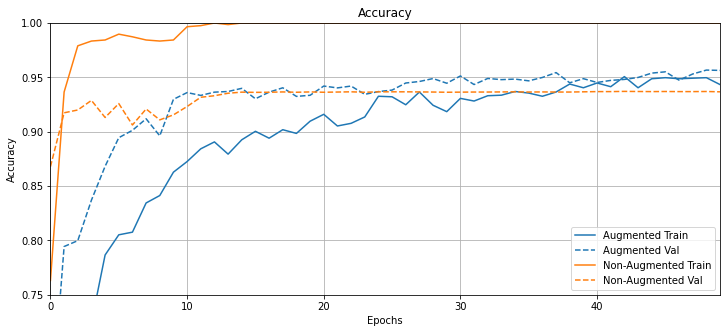

In [22]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

In terms of loss, the non-augmented model is obviously in the overfitting regime. The augmented model, while a few epoch slower, is still training correctly and clearly not overfitting.

(0.0, 1.0)

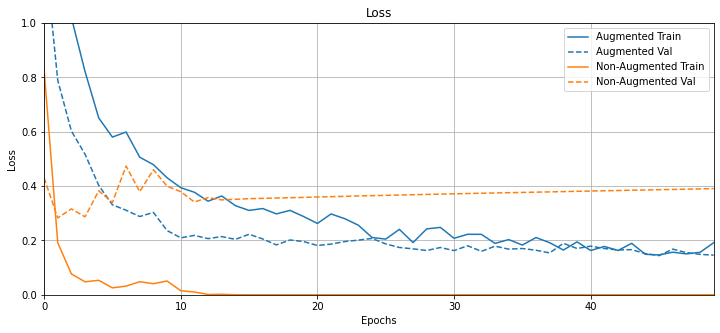

In [23]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])